The State Space, what Huggy perceives.
Huggy doesn't "see" his environment. Instead, we provide him information about the environment:
- The target (stick) position
- The relative position between himself and the target
- The orientation of his legs.
- Given all this information, Huggy can use his policy to determine which action to take next to fulfill his goal.

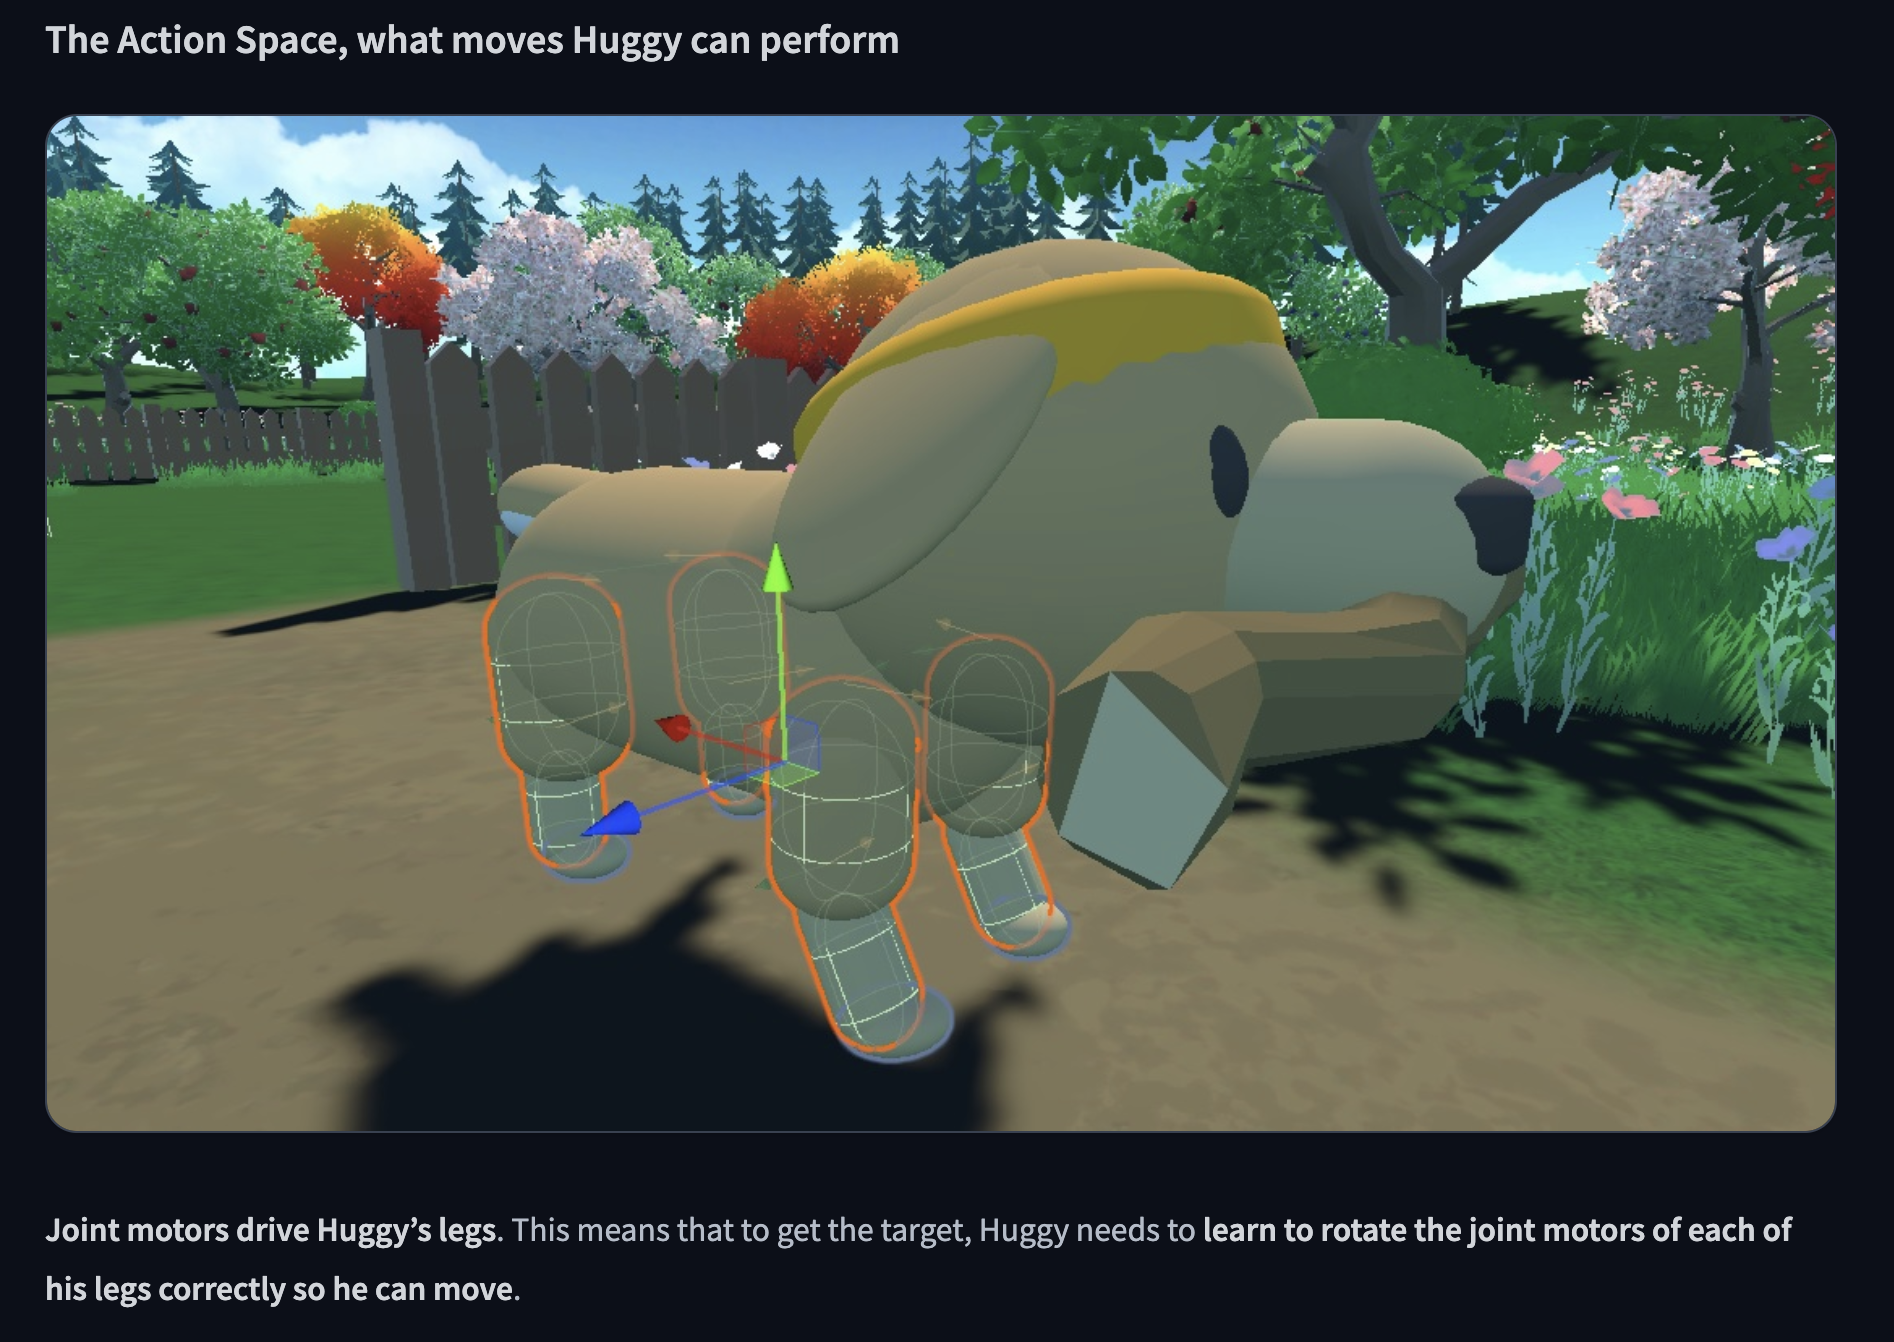

# The Reward Function
- Orientation bonus: we reward him for getting close to the target.
- Time penalty: a fixed-time penalty given at every action to force him to get to the stick as fast as possible.
- Rotation penalty: we penalize Huggy if he spins too much and turns too quickly.
- Getting to the target reward: we reward Huggy for reaching the target.

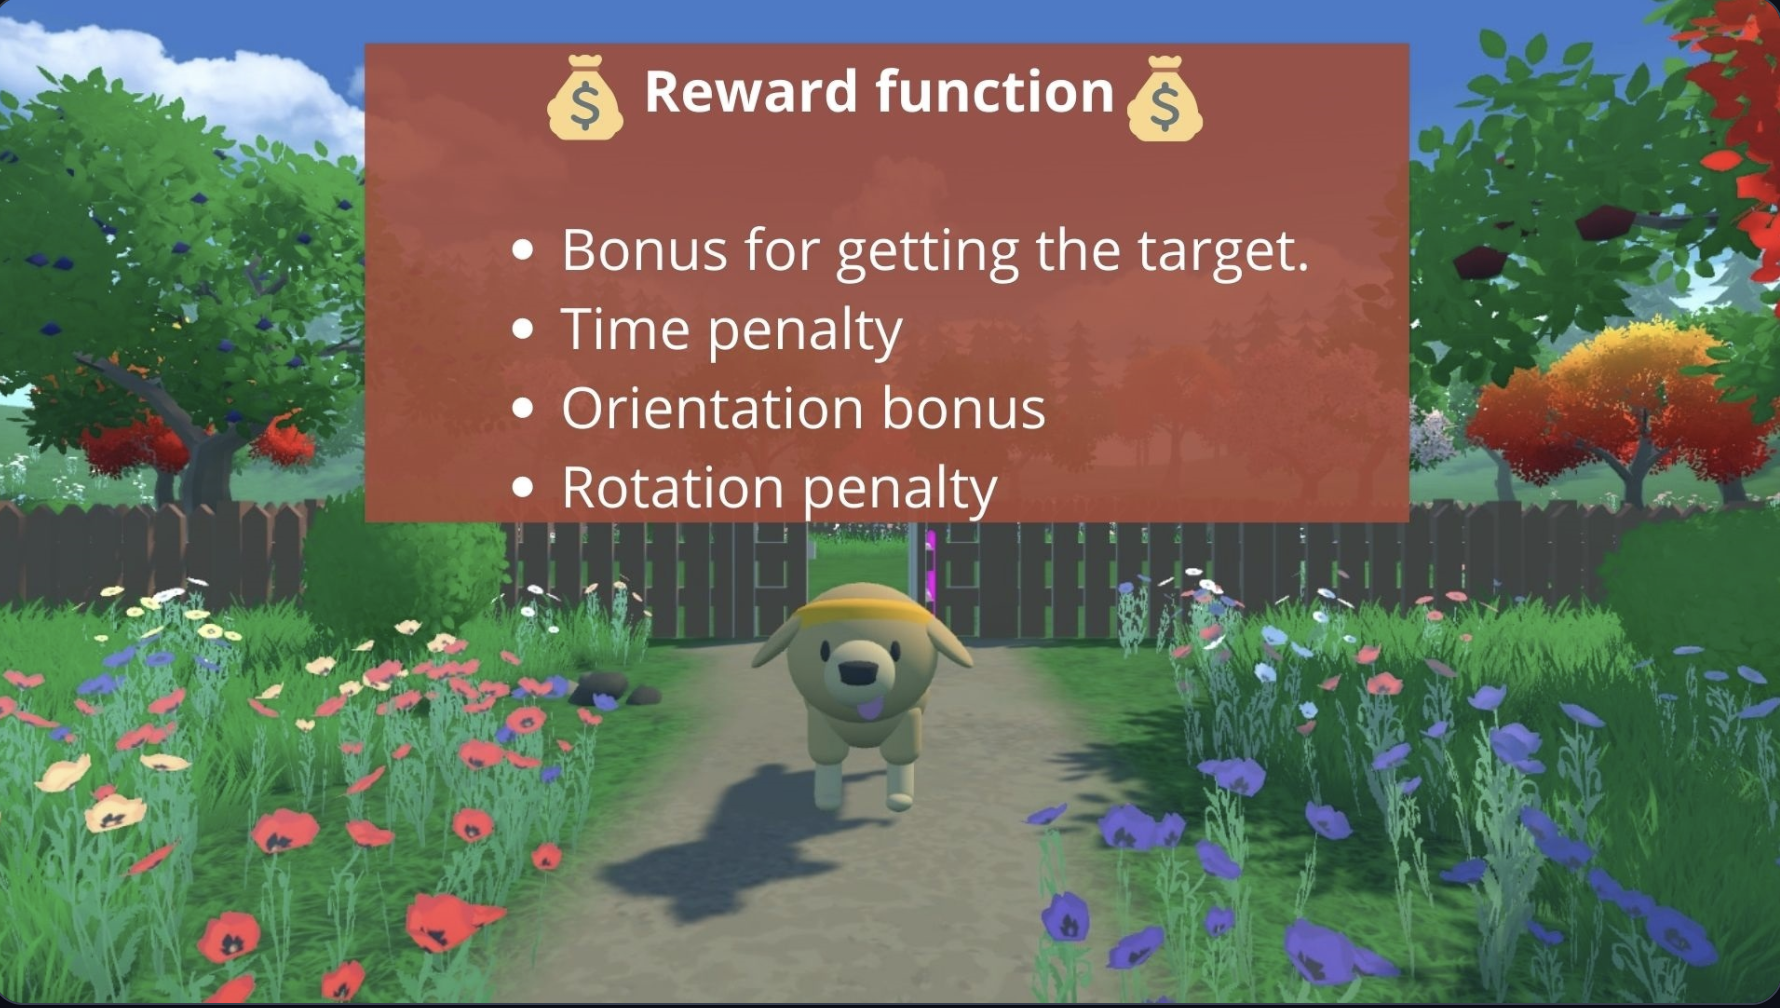

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/huggy.mp4" type="video/mp4"></video>

## Objectives of this notebook 🏆

At the end of the notebook, you will:

- Understand **the state space, action space and reward function used to train Huggy**.
- **Train your own Huggy** to fetch the stick.
- Be able to play **with your trained Huggy directly in your browser**.

## Prerequisites 🏗️

Before diving into the notebook, you need to:

🔲 📚 **Develop an understanding of the foundations of Reinforcement learning** (MC, TD, Rewards hypothesis...) by doing Unit 1

🔲 📚 **Read the introduction to Huggy** by doing Bonus Unit 1

## Clone the repository and install the dependencies 🔽

- We need to clone the repository, that contains **ML-Agents.**

In [ ]:
#@title Install Rendering Dependencies { display-mode: "form" }
#@markdown (You only need to run this code when using Colab's hosted runtime)

import os
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

pro_bar = display(progress(0, 100), display_id=True)

try:
  import google.colab
  INSTALL_XVFB = True
except ImportError:
  INSTALL_XVFB = 'COLAB_ALWAYS_INSTALL_XVFB' in os.environ

if INSTALL_XVFB:
  with open('frame-buffer', 'w') as writefile:
    writefile.write("""#taken from https://gist.github.com/jterrace/2911875
XVFB=/usr/bin/Xvfb
XVFBARGS=":1 -screen 0 1024x768x24 -ac +extension GLX +render -noreset"
PIDFILE=./frame-buffer.pid
case "
PIDFILE --make-pidfile --background --exec
XVFBARGS
    echo "."
    ;;
  stop)
    echo -n "Stopping virtual X frame buffer: Xvfb"
    /sbin/start-stop-daemon --stop --quiet --pidfile
PIDFILE
    echo "."
    ;;
  restart)

0 start
    ;;
  *)
        echo "Usage: /etc/init.d/xvfb {start|stop|restart}"
        exit 1
esac
exit 0
    """)
  !sudo apt-get update
  pro_bar.update(progress(10, 100))
  !sudo DEBIAN_FRONTEND=noninteractive apt install -y daemon wget gdebi-core build-essential libfontenc1 libfreetype6 xorg-dev xorg
  pro_bar.update(progress(20, 100))
  !wget http://security.ubuntu.com/ubuntu/pool/main/libx/libxfont/libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb 2>&1
  pro_bar.update(progress(30, 100))
  !wget --output-document xvfb.deb http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.18.4-0ubuntu0.12_amd64.deb 2>&1
  pro_bar.update(progress(40, 100))
  !sudo dpkg -i libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb 2>&1
  pro_bar.update(progress(50, 100))
  !sudo dpkg -i xvfb.deb 2>&1
  pro_bar.update(progress(70, 100))
  !rm libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb
  pro_bar.update(progress(80, 100))
  !rm xvfb.deb
  pro_bar.update(progress(90, 100))
  !bash frame-buffer start
  os.environ["DISPLAY"] = ":1"
pro_bar.update(progress(100, 100))

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [458 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [860 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,136 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [980 kB]
Hit:13 https://ppa.

In [ ]:
%%capture
# Clone the repository (can take 3min)
!git clone --depth 1 https://github.com/Unity-Technologies/ml-agents

In [ ]:
%%capture
# Go inside the repository and install the package (can take 3min)
%cd ml-agents
!pip3 install -e ./ml-agents-envs
!pip3 install -e ./ml-agents

## Download and move the environment zip file in `./trained-envs-executables/linux/`

- Our environment executable is in a zip file.
- We need to download it and place it to `./trained-envs-executables/linux/`

In [ ]:
!mkdir ./trained-envs-executables
!mkdir ./trained-envs-executables/linux

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zv3M95ZJTWHUVOWT6ckq_cm98nft8gdF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zv3M95ZJTWHUVOWT6ckq_cm98nft8gdF" -O ./trained-envs-executables/linux/Huggy.zip && rm -rf /tmp/cookies.txt

--2023-08-20 12:44:12--  https://docs.google.com/uc?export=download&confirm=t&id=1zv3M95ZJTWHUVOWT6ckq_cm98nft8gdF
Resolving docs.google.com (docs.google.com)... 142.251.8.113, 142.251.8.101, 142.251.8.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.8.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-28-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rm359thqkeoaub8g82clreqlvj041hem/1692535425000/15803371278684422230/*/1zv3M95ZJTWHUVOWT6ckq_cm98nft8gdF?e=download&uuid=53c0dace-7909-4dfb-8bc0-3bc8e54de12c [following]
--2023-08-20 12:44:14--  https://doc-0k-28-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rm359thqkeoaub8g82clreqlvj041hem/1692535425000/15803371278684422230/*/1zv3M95ZJTWHUVOWT6ckq_cm98nft8gdF?e=download&uuid=53c0dace-7909-4dfb-8bc0-3bc8e54de12c
Resolving doc-0k-28-docs.googleusercontent.com (doc-0k-28-docs.googleusercontent.com)... 74.125.204.132, 2404

Download the file Huggy.zip from https://drive.google.com/uc?export=download&id=1zv3M95ZJTWHUVOWT6ckq_cm98nft8gdF using `wget`. Check out the full solution to download large files from GDrive [here](https://bcrf.biochem.wisc.edu/2021/02/05/download-google-drive-files-using-wget/)

In [ ]:
%%capture
!unzip -d ./trained-envs-executables/linux/ ./trained-envs-executables/linux/Huggy.zip

Make sure your file is accessible

In [ ]:
!chmod -R 755 ./trained-envs-executables/linux/Huggy

## Create the Huggy config file

- In ML-Agents, you define the **training hyperparameters into config.yaml files.**

- For the scope of this notebook, we're not going to modify the hyperparameters, but if you want to try as an experiment, you should also try to modify some other hyperparameters, Unity provides very [good documentation explaining each of them here](https://github.com/Unity-Technologies/ml-agents/blob/main/docs/Training-Configuration-File.md).

- But we need to create a config file for Huggy.

  - To do that click on Folder logo on the left of your screen.

  <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/create_file.png" alt="Create file" width="10%">

  - Go to `/content/ml-agents/config/ppo`
  - Right mouse click and create a new file called `Huggy.yaml`

  <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/create-huggy.png" alt="Create huggy.yaml" width="20%">

- Copy and paste the content below 🔽

In [ ]:
!pwd

/content/ml-agents


In [ ]:
%%writefile /content/ml-agents/config/ppo/Huggy.yaml
behaviors:
  Huggy:
    trainer_type: ppo
    hyperparameters:
      batch_size: 2048
      buffer_size: 20480
      learning_rate: 0.0003
      beta: 0.005
      epsilon: 0.2
      lambd: 0.95
      num_epoch: 3
      learning_rate_schedule: linear
    network_settings:
      normalize: true
      hidden_units: 512
      num_layers: 3
      vis_encode_type: simple
    reward_signals:
      extrinsic:
        gamma: 0.995
        strength: 1.0
    checkpoint_interval: 200000
    keep_checkpoints: 15
    max_steps: 2e6
    time_horizon: 1000
    summary_freq: 50000

Writing /content/ml-agents/config/ppo/Huggy.yaml


- **In the case you want to modify the hyperparameters**, in Google Colab notebook, you can click here to open the config.yaml: `/content/ml-agents/config/ppo/Huggy.yaml`

- For instance **if you want to save more models during the training** (for now, we save every 200,000 training timesteps). You need to modify:
  - `checkpoint_interval`: The number of training timesteps collected between each checkpoint.
  - `keep_checkpoints`: The maximum number of model checkpoints to keep.

=> Just keep in mind that **decreasing the `checkpoint_interval` means more models to upload to the Hub and so a longer uploading time**
We’re now ready to train our agent 🔥.

## Train our agent

To train our agent, we just need to **launch mlagents-learn and select the executable containing the environment.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/mllearn.png" alt="ml learn function" width="100%">

With ML Agents, we run a training script. We define four parameters:

1. `mlagents-learn <config>`: the path where the hyperparameter config file is.
2. `--env`: where the environment executable is.
3. `--run_id`: the name you want to give to your training run id.
4. `--no-graphics`: to not launch the visualization during the training.

Train the model and use the `--resume` flag to continue training in case of interruption.

> It will fail first time when you use `--resume`, try running the block again to bypass the error.

## Train our agent

To train our agent, we just need to **launch mlagents-learn and select the executable containing the environment.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/mllearn.png" alt="ml learn function" width="100%">

With ML Agents, we run a training script. We define four parameters:

1. `mlagents-learn <config>`: the path where the hyperparameter config file is.
2. `--env`: where the environment executable is.
3. `--run_id`: the name you want to give to your training run id.
4. `--no-graphics`: to not launch the visualization during the training.

Train the model and use the `--resume` flag to continue training in case of interruption.

> It will fail first time when you use `--resume`, try running the block again to bypass the error.



In [ ]:
!mlagents-learn ./config/ppo/Huggy.yaml --env=./trained-envs-executables/linux/Huggy/Huggy --run-id="Huggy" --no-graphics


            ┐  ╖
        ╓╖╬│╡  ││╬╖╖
    ╓╖╬│││││┘  ╬│││││╬╖
 ╖╬│││││╬╜        ╙╬│││││╖╖                               ╗╗╗
 ╬╬╬╬╖││╦╖        ╖╬││╗╣╣╣╬      ╟╣╣╬    ╟╣╣╣             ╜╜╜  ╟╣╣
 ╬╬╬╬╬╬╬╬╖│╬╖╖╓╬╪│╓╣╣╣╣╣╣╣╬      ╟╣╣╬    ╟╣╣╣ ╒╣╣╖╗╣╣╣╗   ╣╣╣ ╣╣╣╣╣╣ ╟╣╣╖   ╣╣╣
 ╬╬╬╬┐  ╙╬╬╬╬│╓╣╣╣╝╜  ╫╣╣╣╬      ╟╣╣╬    ╟╣╣╣ ╟╣╣╣╙ ╙╣╣╣  ╣╣╣ ╙╟╣╣╜╙  ╫╣╣  ╟╣╣
 ╬╬╬╬┐     ╙╬╬╣╣      ╫╣╣╣╬      ╟╣╣╬    ╟╣╣╣ ╟╣╣╬   ╣╣╣  ╣╣╣  ╟╣╣     ╣╣╣┌╣╣╜
 ╬╬╬╜       ╬╬╣╣      ╙╝╣╣╬      ╙╣╣╣╗╖╓╗╣╣╣╜ ╟╣╣╬   ╣╣╣  ╣╣╣  ╟╣╣╦╓    ╣╣╣╣╣
 ╙   ╓╦╖    ╬╬╣╣   ╓╗╗╖            ╙╝╣╣╣╣╝╜   ╘╝╝╜   ╝╝╝  ╝╝╝   ╙╣╣╣    ╟╣╣╣
   ╩╬╬╬╬╬╬╦╦╬╬╣╣╗╣╣╣╣╣╣╣╝                                             ╫╣╣╣╣
      ╙╬╬╬╬╬╬╬╣╣╣╣╣╣╝╜
          ╙╬╬╬╣╣╣╜
             ╙
        
 Version information:
  ml-agents: 0.31.0.dev0,
  ml-agents-envs: 0.31.0.dev0,
  Communicator API: 1.5.0,
  PyTorch: 1.11.0+cu102
[INFO] Connected to Unity environment with package version 2.2.1-exp.1 and communication version 1.5.0
[INFO] Connected new brain: Huggy?team=0

## Push the agent to the 🤗 Hub

- Now that we trained our agent, we’re **ready to push it to the Hub to be able to play with Huggy on your browser🔥.**

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/create-token.jpg" alt="Create HF Token">

- Copy the token
- Run the cell below and paste the token

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

And we define 4 parameters:

1. `--run-id`: the name of the training run id.
2. `--local-dir`: where the agent was saved, it’s results/<run_id name>, so in my case results/First Training.
3. `--repo-id`: the name of the Hugging Face repo you want to create or update. It’s always <your huggingface username>/<the repo name>
If the repo does not exist **it will be created automatically**
4. `--commit-message`: since HF repos are git repository you need to define a commit message.

In [ ]:
!mlagents-push-to-hf --run-id="HuggyTraining" --local-dir="./results/Huggy" --repo-id="Andyrasika/ppo-Huggy" --commit-message="Huggy"

[INFO] This function will create a model card and upload your HuggyTraining into HuggingFace Hub. This is a work in progress: If you encounter a bug, please send open an issue
[INFO] Pushing repo HuggyTraining to the Hugging Face Hub
Huggy-1199986.onnx:   0% 0.00/2.27M [00:00<?, ?B/s]
Huggy-1399356.onnx:   0% 0.00/2.27M [00:00<?, ?B/s]

Huggy-1399356.pt:   0% 0.00/13.5M [00:00<?, ?B/s]


Huggy-1199986.pt:   0% 0.00/13.5M [00:00<?, ?B/s]



Upload 25 LFS files:   0% 0/25 [00:00<?, ?it/s]




Huggy-1599970.onnx:   0% 0.00/2.27M [00:00<?, ?B/s]


Huggy-1199986.pt:   0% 16.4k/13.5M [00:00<11:53, 18.9kB/s]
Huggy-1399356.onnx:   1% 16.4k/2.27M [00:00<02:01, 18.6kB/s]




Huggy-1599970.onnx:   1% 16.4k/2.27M [00:00<02:00, 18.7kB/s]

Huggy-1199986.onnx:   1% 16.4k/2.27M [00:00<02:03, 18.2kB/s]


Huggy-1199986.pt:   1% 98.3k/13.5M [00:01<01:53, 118kB/s] 
Huggy-1399356.onnx:   4% 98.3k/2.27M [00:01<00:18, 117kB/s] 




Huggy-1599970.onnx:   6% 131k/2.27M [00:01<00:13, 159kB/s]  

Huggy-1199986.o

Else, if everything worked you should have this at the end of the process(but with a different url 😆) :



```
Your model is pushed to the hub. You can view your model here: https://huggingface.co/ThomasSimonini/ppo-Huggy
```

It’s the link to your model repository. The repository contains a model card that explains how to use the model, your Tensorboard logs and your config file. **What’s awesome is that it’s a git repository, which means you can have different commits, update your repository with a new push, open Pull Requests, etc.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/modelcard.png" alt="ml learn function" width="100%">

## Play with your Huggy 🐕

This step is the simplest:

- Open the game Huggy in your browser: https://huggingface.co/spaces/ThomasSimonini/Huggy

- Click on Play with my Huggy model

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit-bonus1/load-huggy.jpg" alt="load-huggy" width="100%">

1. In step 1, choose your model repository which is the model id (in my case AndyRasika/ppo-Huggy).

2. In step 2, **choose what model you want to replay**:
  - I have multiple ones, since we saved a model every 500000 timesteps.
  - But since I want the more recent, I choose `Huggy.onnx`

👉 What’s nice **is to try with different models steps to see the improvement of the agent.**